# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

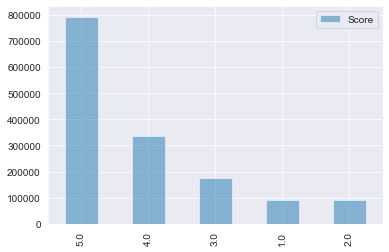


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [19]:
print(trainingSet.columns)
print(testingSet.columns)

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score'],
      dtype='object')
Index(['Id', 'Score'], dtype='object')


# Adding Features

In [3]:
# Load the VADER sentiment lexicon
nltk.download('vader_lexicon')
# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()
# Define a function to calculate sentiment scores
def calculate_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']
# Apply sentiment analysis to the text data
trainingSet['sentiment'] = trainingSet['Text'].apply(lambda x: sia.polarity_scores(str(x))['compound'] if isinstance(x, str) else None)
# Additional Feature Engineering Example
def add_more_features_to(df):
    # Existing Helpfulness feature
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['ReviewLength'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['ReviewYear'] = pd.to_datetime(df['Time'], unit='s').dt.year

    return df
# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    print("read X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
    print("read X_submission.csv")
else:
    # Assuming trainingSet and testingSet are previously loaded DataFrames
    train = add_more_features_to(trainingSet)
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(testingSet, train, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nickg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


read X_train.csv
read X_submission.csv


# Sample + Split into training and testing set

In [4]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)



# Feature Selection

In [5]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'ReviewLength', 'ReviewYear', 'sentiment']
# Select existing features in X_train
existing_train_features = [feature for feature in features if feature in X_train.columns]
# Select data for training and testing
X_train_select = X_train[existing_train_features]
X_test_select = X_test[existing_train_features]
# Select features that exist in both training and submission datasets
common_features = [feature for feature in existing_train_features if feature in X_submission.columns]
# Select data for submission
X_submission_select = pd.DataFrame()
if common_features:
    X_submission_select = X_submission[common_features]


# Model Creation

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Select features that exist in both training and submission datasets
common_features = [feature for feature in existing_train_features if feature in X_submission.columns]

# Define the model
model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Define the stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use X_train_select and Y_train in GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=3)

# Run the grid search on the full dataset
grid_search.fit(X_train_select, Y_train)

# Evaluate the best model on the training values
Y_train_predictions = grid_search.best_estimator_.predict(X_train_select)
print("Accuracy on training values = ", accuracy_score(Y_train, Y_train_predictions))

# Evaluate the best model on the test values
Y_test_predictions = grid_search.best_estimator_.predict(X_test_select)
print("Accuracy on test values = ", accuracy_score(Y_test, Y_test_predictions))

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Create the submission file
X_submission_select = X_submission[common_features]
submission_predictions = best_model.predict(X_submission_select)
submission = X_submission[['Id']]
submission['Score'] = submission_predictions
submission.to_csv("./data/submission.csv", index=False)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Accuracy on training values =  0.5542282126202306
Accuracy on test values =  0.5525696404334619


C:\Users\nickg\AppData\Local\Temp\ipykernel_22368\2063629964.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['Score'] = submission_predictions


# Model Evaluation

Accuracy on testing set =  0.5525696404334619


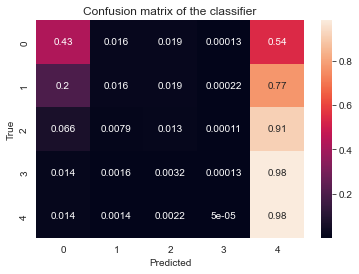

In [7]:
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [8]:
# Create the submission file
X_submission['Score'] = best_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)